In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from datetime import datetime, timedelta
import ccxt
import joblib
import ta
import matplotlib.pyplot as plt

In [31]:
# Load the trained model
model = load_model('V5/models/2-V5-model_2023-06-20-09-13.h5', compile=False)
model.compile(optimizer='adam', loss='mean_squared_error')

# Load the model weights
model.load_weights('V5/models/V5-weights_2023-06-20-09-13.h5')

# Load the scaler
scaler = joblib.load('V5/models/V5-scaler_2023-06-20-09-13.joblib')


In [32]:
# Define the time frame, symbol, and minutes
timeframe = '1m'
symbol = 'BTC/USDT'
minutes = 60
since = datetime.now() - timedelta(minutes=minutes)
since = int(since.timestamp() * 1000)
limit = minutes + 1
show_more_graph = False

In [33]:
# Use ccxt to fetch the last 2 hours of data
exchange = ccxt.binance()

# Use ccxt to fetch the last 60 minutes of data
last_60_minutes = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
last_60_minutes = pd.DataFrame(last_60_minutes, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])


In [34]:
# Compute RSI
last_60_minutes['RSI'] = ta.momentum.rsi(close=last_60_minutes["Close"], fillna=True)

# Compute MACD
last_60_minutes['MACD'] = ta.trend.macd(close=last_60_minutes["Close"], fillna=True)
last_60_minutes['MACD_signal'] = ta.trend.macd_signal(close=last_60_minutes["Close"], fillna=True)
last_60_minutes['MACD_diff'] = ta.trend.macd_diff(close=last_60_minutes["Close"], fillna=True)

# Weighted_Price
last_60_minutes['Weighted_Price'] = (last_60_minutes['High'] + last_60_minutes['Low'] + last_60_minutes['Close']) / 3


In [35]:
# Set the column order to match the scaler
columns_order = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'MACD_signal', 'MACD_diff', 'Weighted_Price']
last_60_minutes = last_60_minutes[columns_order]

In [36]:
# Scale the data using the same scaler
last_60_minutes_scaled = scaler.fit_transform(last_60_minutes[columns_order])
last_60_minutes_scaled = np.reshape(last_60_minutes_scaled, (1, last_60_minutes_scaled.shape[0], last_60_minutes_scaled.shape[1]))

In [37]:
# Make predictions using the LSTM model
predictions = model.predict(last_60_minutes_scaled)
predictions = scaler.inverse_transform(predictions)

1/1 [==============================] - 0s 397ms/step


In [38]:
# Print the predictions
print("Predicted Prices:")
print(predictions)


Predicted Prices:
[[2.6794734e+04 2.6801982e+04 2.6790205e+04 2.6794564e+04 5.5723892e+01
  6.6795723e+01 1.3421935e+00 2.1018984e+00 7.4180019e-01 2.6797068e+04]]


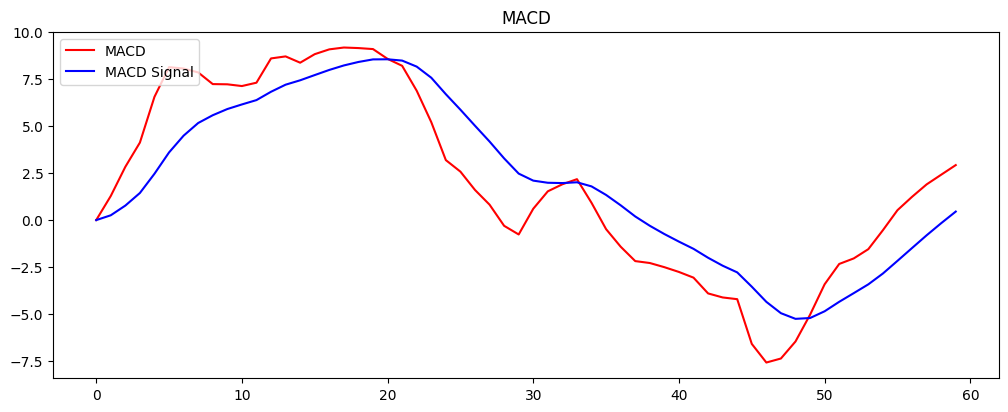

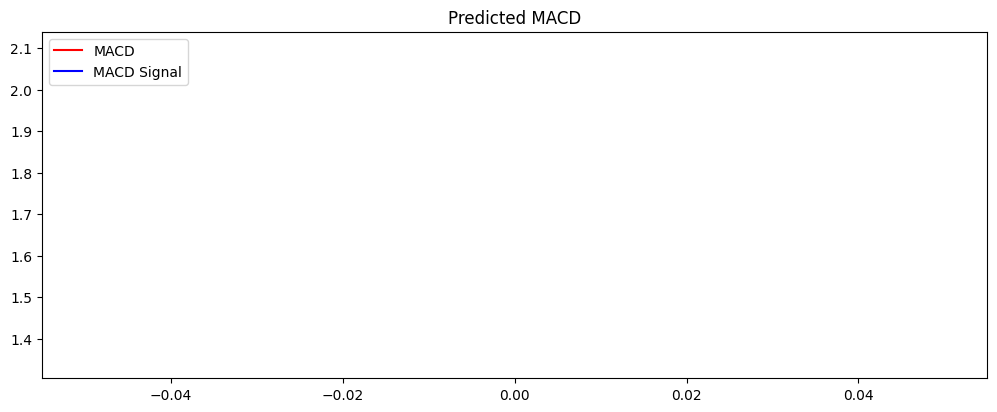

In [59]:
import matplotlib.pyplot as plt

# Plot the actual MACD and MACD Signal
plt.figure(figsize=(12.2, 4.5))
plt.plot(last_60_minutes['MACD'], label='MACD', color='red')
plt.plot(last_60_minutes['MACD_signal'], label='MACD Signal', color='blue')
plt.title('MACD')
plt.legend(loc='upper left')
plt.show()

# Plot the predicted MACD and MACD Signal
plt.figure(figsize=(12.2, 4.5))
plt.plot(predictions[:, 6], label='MACD', color='red')
plt.plot(predictions[:, 7], label='MACD Signal', color='blue')
plt.title('Predicted MACD')
plt.legend(loc='upper left')
plt.show()


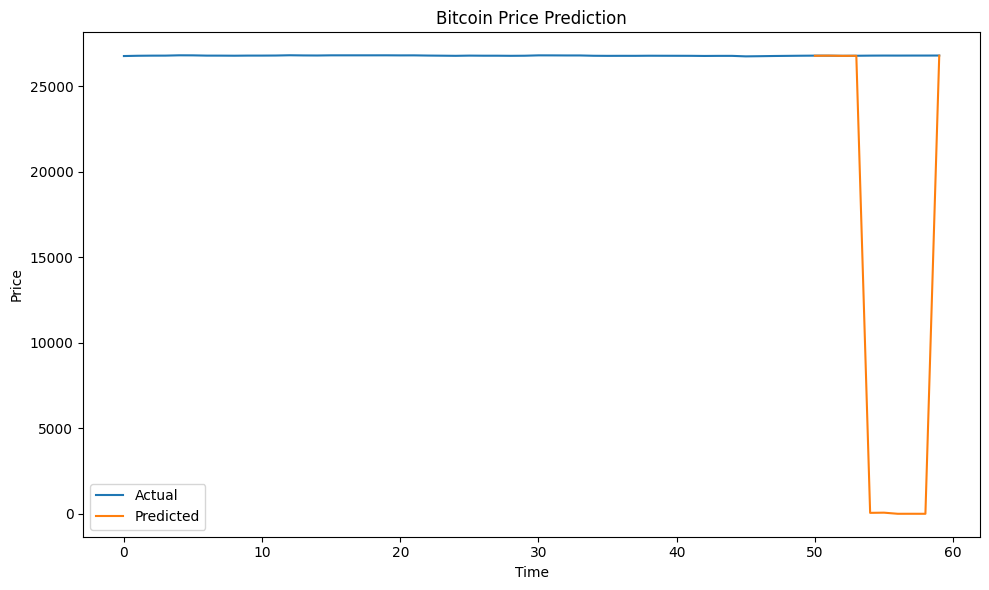

In [39]:
# Plot the actual and predicted values
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(last_60_minutes.index, last_60_minutes['Close'], label='Actual')
ax.plot(last_60_minutes.index[-10:], predictions[0], label='Predicted')
ax.set_title('Bitcoin Price Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.legend()
plt.tight_layout()
plt.show()
